# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Adapted from ddpg implementation from : https://github.com/tommytracey/DeepRL-P2-Continuous-Control/blob/master/Continuous_Control_v8.ipynb

In [ ]:
# when running in Udacity workspace
#!pip -q install ./python

In [2]:
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
## when running locally
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

## when running via AWS EC2
# env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

## when running in Udacity workspace
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default Brain that will handle all the agents
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
Code adapted from https://github.com/tommytracey/DeepRL-P2-Continuous-Control

In [6]:
#env.reset(train_mode=True)[brain_name]
#env.close()

In [7]:
# Defaults for our project have been selected.
def ddpg(n_episodes=500, max_t=1000, solved_score=30.0, consec_episodes=100, train_mode=True, learn_every=20, num_learn=10, 
         actor_path='results_actor_ckpt.pth', critic_path='results_critic_ckpt.pth'):    
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min average score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    mean_episode_scores = []                               # list of mean scores from each episode
    min_episode_scores = []                                # list of lowest scores from each episode
    max_episode_scores = []                                # list of highest scores from each episode
    best_score = -np.inf                           # floating point representation of negative infinity.
    mean_scores_window = deque(maxlen=consec_episodes)  # mean scores from M most recent episodes 
    moving_averages = []                               # list of moving averages    
    #time_steps = 20 - handled in Agent
    #update = 10 - handled in Agent
    
    # The TIME_STEP interval is a part of the agent typically it is set to 20
    # The UPDATE frequency is also part of the agent code and is typically set to 10
    
    #train_mode = True
    #env_info = env.reset(train_mode=train_mode)[brain_name]
    #states = env_info.vector_observations      
        
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()
        # Reset the environment, states and scores  
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(n_agents) # score for each agent within episode   
        agent.reset()
        for t in range(max_t):
            # A single step of interaction with the environment for each agent
            actions = agent.act(states,add_noise=True)
            # take action step in and update in the environment and get the next state
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done     
            # Perform step of training 
            # Save experience to replay buffer, perform learning step at defined interval
            # The memory update step takes place actually inside the agent so its easy to parametrize it there
            #agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            if train_mode:
                # try next:
                # agent.step_multi(states, actions, rewards, next_states, dones, t)
                
                for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                    agent.step(state, action, reward, next_state, done) # send actions to the agent
                scores += env_info.rewards   #?+= np.array(rewards)  # scores += np.array(rewards)
                # for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                # agent.step_multi(state, action, reward, next_state, done, t)           
                # Sum up rewards separately for each agent
                
                # Prepare for next time step by making new states become the current states
                states = next_states  
                
                if t%learn_every == 0:
                    for _ in range(num_learn):
                        agent.start_learn()
            # Check if any of the agents has finished.  
            # Exit loop when episode ends
            # Keep collected parts in the batch the same size.
            if np.any(dones):
                break
        time_taken = time.time() - start_time
        min_episode_scores.append(np.min(scores))          # save episode min  score for agent
        max_episode_scores.append(np.max(scores))          # save episode max score for agent        
        mean_episode_scores.append(np.mean(scores))          # save episode mean score for the episode
        mean_scores_window.append(mean_episode_scores[-1])    # save mean score to window
        moving_averages.append(np.mean(mean_scores_window))  # save moving average
        
         #if i_episode % print_every == 0:
        print('\rEpisode {} ({} sec)  -- \tMin Scores: {:.1f}\tMax Scores: {:.1f}\tMean Scores: {:.1f}\tMoving Average: {:.1f}'.format(\
                  i_episode, round(time_taken),min_episode_scores[-1], max_episode_scores[-1], mean_episode_scores[-1], moving_averages[-1]))
        
        if train_mode and mean_scores_window[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if moving_averages[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_averages[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
    return mean_episode_scores, moving_averages

In [8]:
# run the training loop

random_seed = 27
train_mode = True
agent = Agent(state_size=state_size, action_size=action_size,random_seed=random_seed)
scores, averages = ddpg(actor_path='results/results_actor_ckpt.pth', critic_path='results/results_critic_ckpt.pth')

D:\Users\dobes.zuzana\AppData\Local\Continuum\anaconda3\envs\drlndold\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
D:\Users\dobes.zuzana\Analytics\Udacity\project 2 - Continuous Control\ddpg_agent.py:105: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 1 (166 sec)  -- 	Min Scores: 0.0	Max Scores: 1.5	Mean Scores: 0.6	Moving Average: 0.6
Episode 2 (178 sec)  -- 	Min Scores: 0.1	Max Scores: 3.2	Mean Scores: 0.9	Moving Average: 0.7
Episode 3 (177 sec)  -- 	Min Scores: 0.3	Max Scores: 1.9	Mean Scores: 1.0	Moving Average: 0.8
Episode 4 (176 sec)  -- 	Min Scores: 0.3	Max Scores: 2.3	Mean Scores: 1.0	Moving Average: 0.9
Episode 5 (177 sec)  -- 	Min Scores: 0.0	Max Scores: 2.1	Mean Scores: 1.1	Moving Average: 0.9
Episode 6 (175 sec)  -- 	Min Scores: 0.5	Max Scores: 2.6	Mean Scores: 1.5	Moving Average: 1.0
Episode 7 (176 sec)  -- 	Min Scores: 0.5	Max Scores: 2.2	Mean Scores: 1.3	Moving Average: 1.1
Episode 8 (176 sec)  -- 	Min Scores: 0.0	Max Scores: 3.4	Mean Scores: 1.6	Moving Average: 1.1
Episode 9 (178 sec)  -- 	Min Scores: 0.4	Max Scores: 3.6	Mean Scores: 1.8	Moving Average: 1.2
Episode 10 (182 sec)  -- 	Min Scores: 0.1	Max Scores: 6.9	Mean Scores: 2.5	Moving Average: 1.3
Episode 11 (182 sec)  -- 	Min Scores: 1.3	Max Scores: 6.1	M

Episode 85 (214 sec)  -- 	Min Scores: 36.3	Max Scores: 39.6	Mean Scores: 38.7	Moving Average: 29.6
Episode 86 (215 sec)  -- 	Min Scores: 36.9	Max Scores: 39.6	Mean Scores: 38.7	Moving Average: 29.7
Episode 87 (222 sec)  -- 	Min Scores: 35.6	Max Scores: 39.2	Mean Scores: 37.7	Moving Average: 29.8
Episode 88 (225 sec)  -- 	Min Scores: 37.1	Max Scores: 39.3	Mean Scores: 38.4	Moving Average: 29.9
Episode 89 (213 sec)  -- 	Min Scores: 36.4	Max Scores: 39.5	Mean Scores: 38.1	Moving Average: 30.0
Episode 90 (204 sec)  -- 	Min Scores: 35.2	Max Scores: 39.6	Mean Scores: 37.3	Moving Average: 30.1
Episode 91 (216 sec)  -- 	Min Scores: 36.2	Max Scores: 39.4	Mean Scores: 38.0	Moving Average: 30.2
Episode 92 (213 sec)  -- 	Min Scores: 34.6	Max Scores: 38.9	Mean Scores: 37.0	Moving Average: 30.3
Episode 93 (216 sec)  -- 	Min Scores: 32.9	Max Scores: 38.8	Mean Scores: 36.6	Moving Average: 30.3
Episode 94 (216 sec)  -- 	Min Scores: 36.0	Max Scores: 39.3	Mean Scores: 38.1	Moving Average: 30.4
Episode 95

### Plot of the learning curve

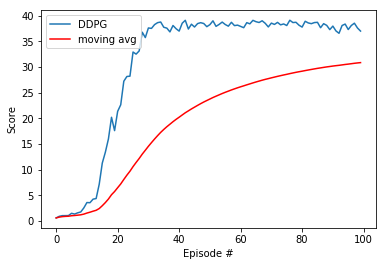

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), averages, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [ ]:
# Load the saved weights into Pytorch model
agent.actor_local.load_state_dict(torch.load('results/results_actor_ckpt.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('results/results_critic_ckpt.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

In [ ]:
# If you get here you have done well!
# Now clean up so you don't get into trouble with memory.
env.close()